# Predicting Customer Spending on Black Friday

## Data cleaning and feature extraction

Import libraries and methods.

In [125]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.utils import shuffle

Read dataset and print features and categories.

In [4]:
df = pd.read_csv('C:/Users/Nolan/.PyCharmCE2018.3/config/scratches/Practice/BlackFriday.csv')

for x in list(df):
    if len(df[x].unique())>21:
        print(x, df[x].unique(), str(len(df[x].unique()))+' categories')
    else:
        print(x, sorted(df[x].unique()))

User_ID [1000001 1000002 1000003 ... 1004113 1005391 1001529] 5891 categories
Product_ID ['P00069042' 'P00248942' 'P00087842' ... 'P00038842' 'P00295642'
 'P00091742'] 3623 categories
Gender ['F', 'M']
Age ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
Occupation [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
City_Category ['A', 'B', 'C']
Stay_In_Current_City_Years ['0', '1', '2', '3', '4+']
Marital_Status [0, 1]
Product_Category_1 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Product_Category_2 [nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
Product_Category_3 [nan, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
Purchase [ 8370 15200  1422 ... 14539 11120 18426] 17959 categories


From the above lists, it is clear that all initial features are categorical.

Check for duplicates.

In [5]:
df.duplicated().sum()

0

No duplicates found.

Next, check the number of missing values.

In [6]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

The only missing values are in product category 2 and 3, for products that belong in less than 3 categories.
The fact that Product_Category_2 does not have the level 1 and Product_Category_3 does not have level 2 suggests
the categories are placed in numerical order. This means the order has no meaning, and the important information is
simply the categories the product belongs to.

Thus we can dummy code all 3 features and add them together.

In [7]:
prodcatdummy1 = pd.get_dummies(df.Product_Category_1).astype(int)
prodcatdummy2 = pd.get_dummies(df.Product_Category_2.fillna(0).astype(int))
prodcatdummy3 = pd.get_dummies(df.Product_Category_3.fillna(0).astype(int))

prodcatdummy = prodcatdummy1

for x in list(prodcatdummy):
    if x in list(prodcatdummy2):
        prodcatdummy[x] += prodcatdummy2[x]
    if x in list(prodcatdummy3):
        prodcatdummy[x] += prodcatdummy3[x]

prodcatdummy=prodcatdummy.rename({x:'PC'+str(x) for x in list(prodcatdummy)},axis=1)
        
prodcatdummy.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


We can combine the three columns into a single column representing the unique combination of categories.

In [8]:
df['Product_Categories']=df['Product_Category_1'].astype(str).str.cat(
    df[['Product_Category_2','Product_Category_3']].astype(str))

combinationdummies =pd.get_dummies(df['Product_Categories'])

print(len(df.Product_Categories.unique()))

235


There are 235 categories in this new feature. To prevent overfitting, this feature might not be used.

Now dummy code the remaining variables.

In [9]:
df['Male']=np.where(df['Gender']=='M',1,0)
agedummies = pd.get_dummies(df['Age'])
occupationdummies =pd.get_dummies(df['Occupation'])
citydummies = pd.get_dummies(df['City_Category'])
staydummies =pd.get_dummies(df['Stay_In_Current_City_Years'])
df['Constant']=1

Next we can create variables for the popularity of products (count) and different products each customer bought.

In [10]:
df['Product_Count']=df['Product_ID'].map(df.groupby('Product_ID')['Purchase'].count())
df['User_Count']=df['User_ID'].map(df.groupby('User_ID')['Purchase'].count())

df[['User_ID','Product_ID','User_Count','Product_Count']].head(10)

,User_ID,Product_ID,User_Count,Product_Count
0,1000001,P00069042,34,221
1,1000001,P00248942,34,570
2,1000001,P00087842,34,99
3,1000001,P00085442,34,334
4,1000002,P00285442,76,200
5,1000003,P00193542,29,606
6,1000004,P00184942,13,1424
7,1000004,P00346142,13,586
8,1000004,P0097242,13,896
9,1000005,P00274942,106,782


Next, we can create a new response of the number purchased. The number purchased may serve as an intermediate response that can be modeled separately if necessary.

In [11]:
pricedict = {}
prices = df.groupby('Product_ID')['Purchase'].min()
for x in df.Product_ID.unique():
    pricedict.update({x:prices.loc[x]})
df['Price']=df['Product_ID'].map(pricedict)
df['Number']=round(df['Purchase']/df['Price']).astype(int)
df['User_Sum']=df['User_ID'].map(df.groupby('User_ID')['Purchase'].sum())
df[['Product_ID','Purchase','Price','Number','User_Sum']].head(10)

,Product_ID,Purchase,Price,Number,User_Sum
0,P00069042,8370,2648,3,333481
1,P00248942,15200,3880,4,333481
2,P00087842,1422,346,4,333481
3,P00085442,1057,365,3,333481
4,P00285442,7969,3920,2,810353
5,P00193542,15227,3828,4,341635
6,P00184942,19215,3809,5,205987
7,P00346142,15854,3847,4,205987
8,P0097242,15686,3936,4,205987
9,P00274942,7871,1940,4,821001


## Exploratory Data Visualization

The counts of each category are plotted below.

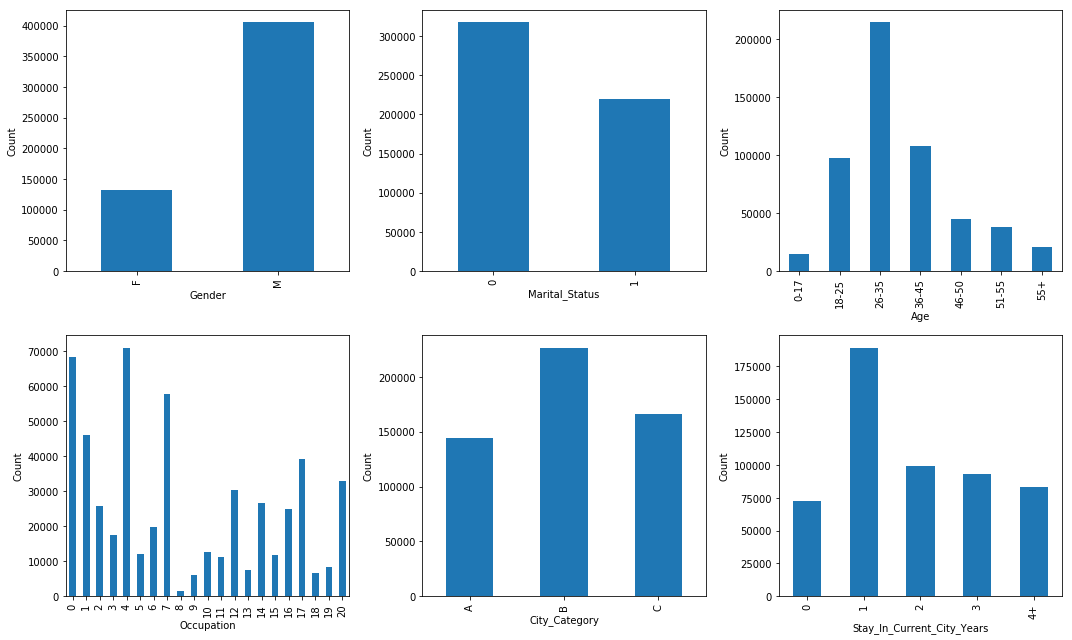

In [12]:
userplotlist=['Gender','Marital_Status','Age','Occupation','City_Category','Stay_In_Current_City_Years']
fig0, ax0 = plt.subplots(2,3)
for i in range(len(userplotlist)):
    df.groupby(userplotlist[i])['Purchase'].count().plot(kind='bar',ax=ax0[i//3,i%3])
    ax0[i//3,i%3].set_ylabel('Count')
fig0.set_size_inches(15,9)
fig0.tight_layout()

There is reasonable variability in each of the categorical variables in the customer population. There is no basis
for excluding any feature yet.

Now perform a quick visual check for independence/balance of variables. For each level of a variable the distribution of other variable should be similar.

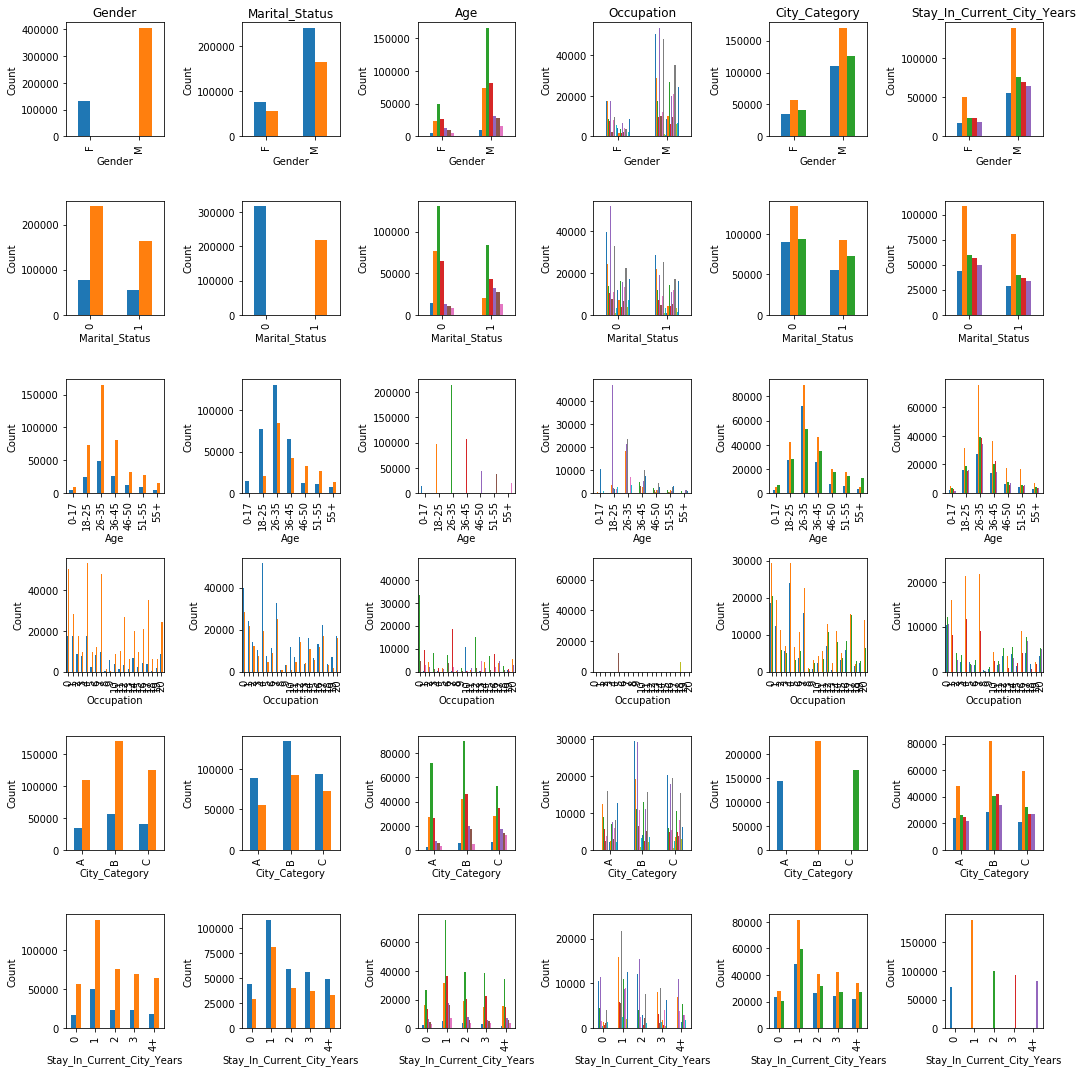

In [13]:
fig3, ax3 = plt.subplots(6,6)
for i in range(len(userplotlist)):
    for j in range(len(userplotlist)):
        df.groupby([userplotlist[i],userplotlist[j]])['Purchase'].count().unstack().plot(kind='bar',ax=ax3[i,j],legend=False)
        ax3[i,j].set_ylabel('Count')
        if i==0:
            ax3[i,j].set_title(userplotlist[j])
fig3.set_size_inches(15,15)
fig3.tight_layout()

Age and marital status are related (older people tend to be married). Occupation and city category and stay in current city appear related as well. However, the correlations are not so strong that independence is lost (most levels are represented
to some degree in each level of the other variable). Therefore there is no basis to combine any variables yet.

The next plot shows the mean total purchase for each categorical variable.

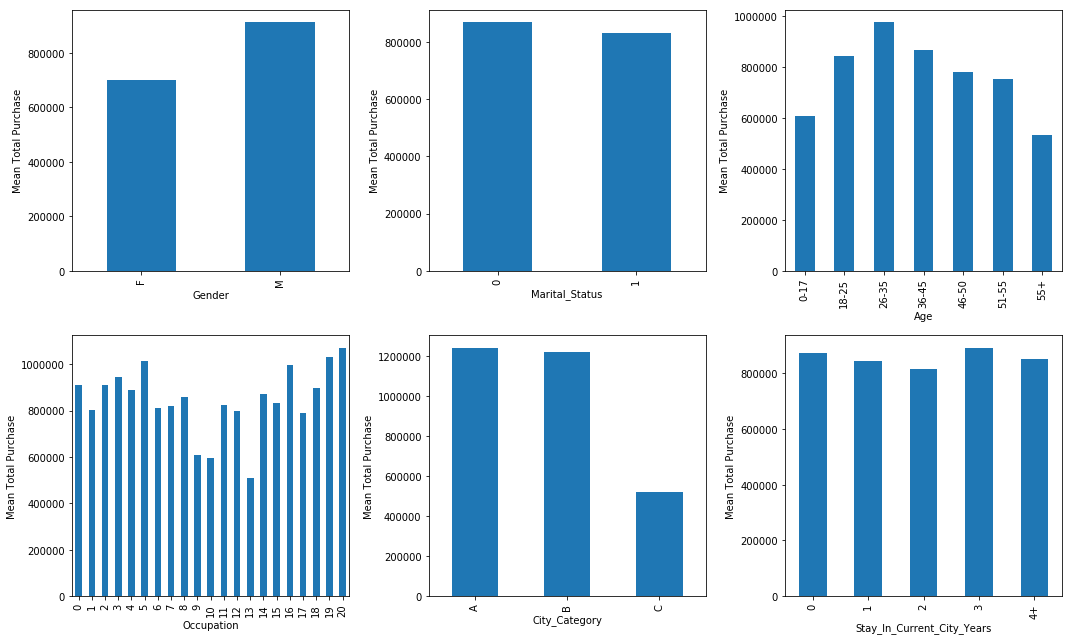

In [14]:
fig1, ax1 = plt.subplots(2,3)
sumdf=df[['User_ID','Gender','Marital_Status','Age','Occupation','City_Category','Stay_In_Current_City_Years','User_Sum']].drop_duplicates()
for i in range(len(userplotlist)):
    sumdf.groupby(userplotlist[i])['User_Sum'].mean().plot(kind='bar',ax=ax1[i//3,i%3])
    ax1[i//3,i%3].set_ylabel('Mean Total Purchase')
fig1.set_size_inches(15,9)
fig1.tight_layout()

City categories A and B are similar, and marital status and stay in current city appear to have little effect on average spending. However, this may differ when the product categories are considered.

The next plot shows the number and total purchase amount for each category of product.

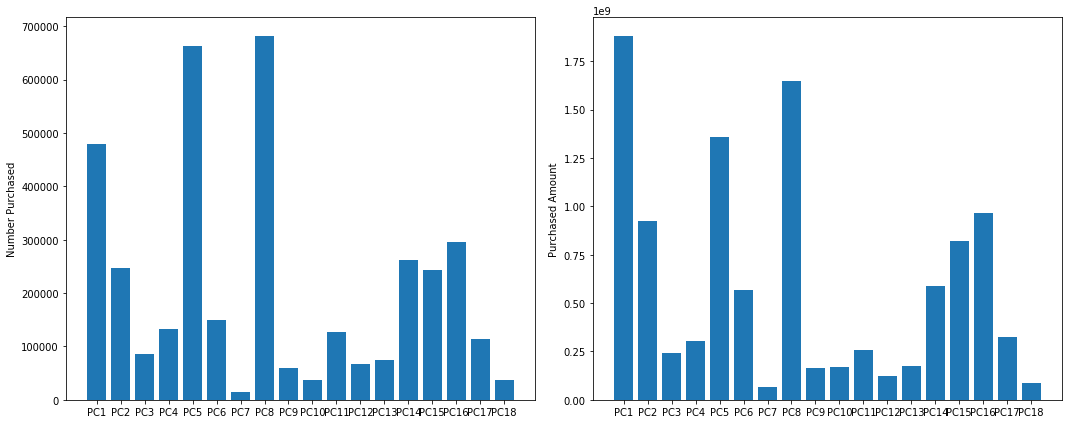

In [15]:
productdf = pd.concat([df[['Product_ID','Number','Purchase']],prodcatdummy],axis=1)
categorynumbertotals = []
categorypurchasetotals = []
for x in list(prodcatdummy):
    categorynumbertotals.append(np.dot(productdf[x],productdf['Number']))
    categorypurchasetotals.append(np.dot(productdf[x],productdf['Purchase']))
fig2, ax2 = plt.subplots(1,2)
ax2[0].bar(list(prodcatdummy),categorynumbertotals)
ax2[0].set_ylabel('Number Purchased')
ax2[1].bar(list(prodcatdummy),categorypurchasetotals)
ax2[1].set_ylabel('Purchased Amount')
fig2.set_size_inches(15,6)
fig2.tight_layout()

The number and amount purchased varies greatly by product category.

## Feature Selection for Least Squares Regression

First scale the continuous variables.

In [16]:
continuous = ['Price','User_Count','Product_Count']
for x in continuous:
    df[x]/=df[x].std()*2

Then create the centered design matrix and response vector.

In [17]:
X=(pd.concat([df[['Constant','Male','Marital_Status','Price','User_Count','Product_Count']], agedummies[list(agedummies)[1:]],
occupationdummies[list(occupationdummies)[1:]],citydummies[list(citydummies)[1:]],staydummies[list(staydummies)[1:]],
prodcatdummy],axis=1)-0.5)*2
y=df['Purchase']

We will first use a linear model to obtain p values.

In [157]:
model = sm.OLS(y,X)
results=model.fit()
resultssummary = results.summary()
resultssummaryhtml = resultssummary.tables[1].as_html()
resultssummarydf = pd.read_html(resultssummaryhtml,header=0,index_col=0)[0]
print(resultssummary)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                 1.543e+04
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:39:44   Log-Likelihood:            -5.0847e+06
No. Observations:              537577   AIC:                         1.017e+07
Df Residuals:                  537521   BIC:                         1.017e+07
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Constant        9273.4215    169.163     54.

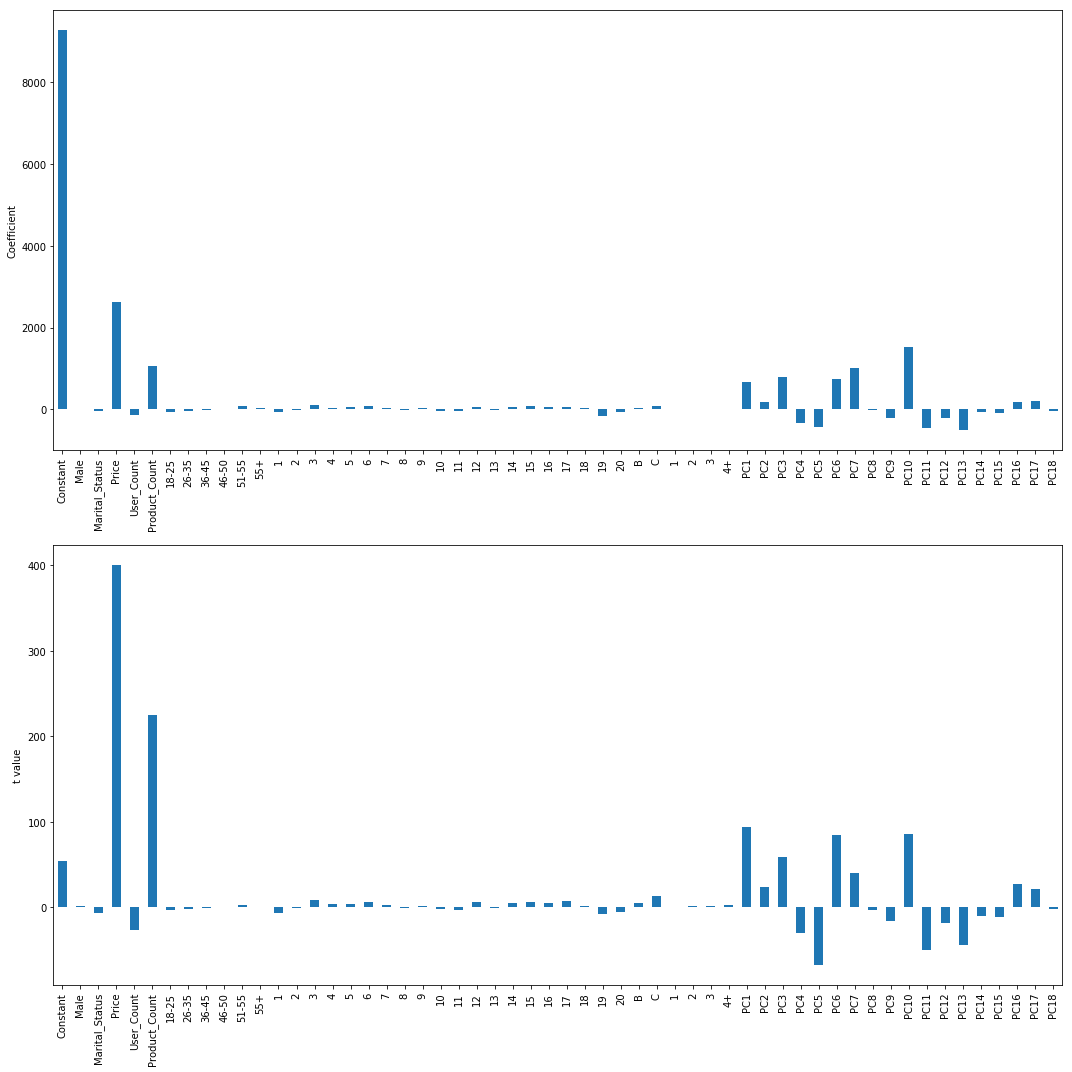

In [162]:
fig4, ax4 = plt.subplots(2,1)
resultssummarydf['coef'].plot(kind='bar',ax=ax4[0])
resultssummarydf['t'].plot(kind='bar',ax=ax4[1])
ax4[0].set_ylabel('Coefficient')
ax4[1].set_ylabel('t value')
fig4.set_size_inches(15,15)
fig4.tight_layout()

It is clear that the purchase amount depends the most on the price, popularity, and category of the product. But the product category effect may differ among different customers. This would be captured by interaction effects.

Because there are so many possible interactions, we will invoke the heirarchy of effects principle and assume significant interactions involve only significant main effects. So first we will check for interactions between significant features. Due to the large number of interactions, 
this will be done in several stages. The levels are first grouped by categorical feature.

In [19]:
sigage = ['18-25','51-55']
sigocc = [1,3,4,5,6,7,11,12,14,15,16,17,18,20]
sigcity = ['B','C']
sigpc = []
for i in range(1,19):
    sigpc.append('PC'+str(i))
sigother = ['Marital_Status','Price','User_Count','Product_Count']
sig = sigother+sigage+sigocc+sigcity+sigpc

First interactions between the all features and features in groups with the least number of categories is evaluated.

In [20]:
X1 = X.copy()
for i in range(len(sig)):
    for j in range(i+1,len(sig)):
        a=sig[i]
        b=sig[j]
        if not (a in sigage and b in sigage) and not (a in sigocc and b in sigocc)\
            and not (a in sigcity and b in sigcity) and not (a in sigpc and b in sigpc)\
            and not (a in sigocc and b in sigpc) and not (a in sigpc and b in sigocc):
                X1[str(a)+'x'+str(b)]=X1[a]*X1[b]
                
y=df['Purchase']

X1.head(10)

,Constant,Male,Marital_Status,Price,User_Count,Product_Count,18-25,26-35,36-45,46-50,...,CxPC9,CxPC10,CxPC11,CxPC12,CxPC13,CxPC14,CxPC15,CxPC16,CxPC17,CxPC18
0,1.0,-1.0,-1.0,1.120588,-0.804753,-0.381538,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,-1.0,2.107206,-0.804753,0.595130,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
2,1.0,-1.0,-1.0,-0.722914,-0.804753,-0.722951,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,-1.0,-1.0,-0.707698,-0.804753,-0.065310,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,-1.0,2.139239,-0.563565,-0.440305,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,1.0,1.0,-1.0,2.065563,-0.833466,0.695875,-1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,2.050347,-0.925347,2.985025,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0
7,1.0,1.0,1.0,2.080778,-0.925347,0.639905,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,2.152052,-0.925347,1.507432,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
9,1.0,1.0,1.0,0.553603,-0.391288,1.188406,-1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
model = sm.OLS(y,X1)
results=model.fit()
summary = results.summary()
summaryhtml = summary.tables[1].as_html()
summarydf = pd.read_html(summaryhtml,header=0,index_col=0)[0]
print(summarydf)

                      coef  std err       t  P>|t|     [0.025     0.975]
Constant        14500.0000  288.544  50.257  0.000  13900.000  15100.000
Male               15.9504    4.965   3.213  0.001      6.220     25.681
Marital_Status    570.9279   90.616   6.301  0.000    393.324    748.532
Price            1038.1643   96.735  10.732  0.000    848.567   1227.762
User_Count       -144.7470  111.262  -1.301  0.193   -362.816     73.322
Product_Count   -4440.0222  109.931 -40.389  0.000  -4655.483  -4224.561
18-25             -95.1387  134.266  -0.709  0.479   -358.296    168.018
26-35             -32.6309   20.663  -1.579  0.114    -73.129      7.867
36-45              18.2178   20.934   0.870  0.384    -22.813     59.248
46-50              19.3909   21.856   0.887  0.375    -23.446     62.228
51-55             831.5974  182.705   4.552  0.000    473.501   1189.694
55+                56.9920   23.315   2.444  0.015     11.296    102.688
1                -138.3672   22.624  -6.116  0.000 

Cells with t value below 5 are screened out. (Some significant interactions are screened out, but this high t value was chosen to filter out more interactions to make the regression analysis more efficient).

In [22]:
significant = summarydf[((summarydf['t']>=5)|(summarydf['t']<=-5))&(summarydf.index.str.contains('x'))].index
print(significant)
print(len(significant))

Index(['Marital_StatusxPrice', 'Marital_Statusx7', 'Marital_Statusx12',
       'Marital_Statusx14', 'Marital_Statusx20', 'PricexProduct_Count',
       'Pricex18-25', 'Pricex1', 'Pricex7', 'Pricex12', 'Pricex14', 'Pricex17',
       'PricexPC1', 'PricexPC2', 'PricexPC3', 'PricexPC4', 'PricexPC5',
       'PricexPC6', 'PricexPC7', 'PricexPC8', 'PricexPC9', 'PricexPC10',
       'PricexPC11', 'PricexPC12', 'PricexPC13', 'PricexPC14', 'PricexPC16',
       'PricexPC17', 'PricexPC18', 'User_CountxProduct_Count', 'User_Countx5',
       'User_Countx6', 'User_Countx11', 'User_Countx16', 'User_CountxB',
       'User_CountxPC1', 'User_CountxPC4', 'User_CountxPC5', 'User_CountxPC10',
       'User_CountxPC17', 'Product_Countx18-25', 'Product_Countx51-55',
       'Product_Countx6', 'Product_CountxPC1', 'Product_CountxPC2',
       'Product_CountxPC3', 'Product_CountxPC4', 'Product_CountxPC5',
       'Product_CountxPC6', 'Product_CountxPC7', 'Product_CountxPC9',
       'Product_CountxPC10', 'Product_Coun

Separately, the interactions between the two features with the most categories (occupation and product type) are evaluated.

In [23]:
X2 = X.copy()
for i in range(len(sigocc)):
    for j in range(len(sigpc)):
        a=sigocc[i]
        b=sigpc[j]
        X2[str(a)+'x'+str(b)]=X2[a]*X2[b]
                
y=df['Purchase']

X2.head(10)

,Constant,Male,Marital_Status,Price,User_Count,Product_Count,18-25,26-35,36-45,46-50,...,20xPC9,20xPC10,20xPC11,20xPC12,20xPC13,20xPC14,20xPC15,20xPC16,20xPC17,20xPC18
0,1.0,-1.0,-1.0,1.120588,-0.804753,-0.381538,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,-1.0,2.107206,-0.804753,0.595130,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
2,1.0,-1.0,-1.0,-0.722914,-0.804753,-0.722951,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,-1.0,-1.0,-0.707698,-0.804753,-0.065310,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,-1.0,2.139239,-0.563565,-0.440305,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,-1.0,2.065563,-0.833466,0.695875,-1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,2.050347,-0.925347,2.985025,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0
7,1.0,1.0,1.0,2.080778,-0.925347,0.639905,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,2.152052,-0.925347,1.507432,-1.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
9,1.0,1.0,1.0,0.553603,-0.391288,1.188406,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [24]:
model = sm.OLS(y,X2)
results2=model.fit()
summary2 = results2.summary()
summaryhtml2 = summary2.tables[1].as_html()
summarydf2 = pd.read_html(summaryhtml2,header=0,index_col=0)[0]
print(summarydf2)

                     coef  std err        t  P>|t|    [0.025     0.975]
Constant        9141.3253  883.657   10.345  0.000  7409.386  10900.000
Male              11.8108    5.195    2.273  0.023     1.629     21.993
Marital_Status   -28.5738    4.605   -6.205  0.000   -37.599    -19.549
Price           2620.2654    6.536  400.891  0.000  2607.455   2633.076
User_Count      -134.0123    5.201  -25.768  0.000  -144.206   -123.819
Product_Count   1066.4779    4.737  225.152  0.000  1057.194   1075.762
18-25            -70.9498   21.314   -3.329  0.001  -112.725    -29.174
26-35            -38.3284   21.253   -1.803  0.071   -79.984      3.327
36-45             -3.8939   21.559   -0.181  0.857   -46.149     38.361
46-50             -1.8568   22.519   -0.082  0.934   -45.993     42.279
51-55             73.7717   22.772    3.240  0.001    29.139    118.404
55+               24.2404   24.120    1.005  0.315   -23.033     71.514
1                207.4069  108.551    1.911  0.056    -5.350    

In [25]:
significant2 = summarydf2[((summarydf2['t']>=5)|(summarydf2['t']<=-5))&(summarydf2.index.str.contains('x'))].index
print(significant2)
print(len(significant2))

Index(['5xPC1', '7xPC1', '17xPC1'], dtype='object')
3


Finally, the 235 different combinations of product category are evaluated.

In [26]:
X3 = pd.concat([X,combinationdummies],axis=1)
y=df['Purchase']
model = sm.OLS(y,X3)
results3=model.fit()
summary3 = results3.summary()
summaryhtml3 = summary3.tables[1].as_html()
summarydf3 = pd.read_html(summaryhtml3,header=0,index_col=0)[0]
print(summarydf3)

                     coef   std err        t  P>|t|    [0.025    0.975]
Constant        7472.3126   210.803   35.447  0.000  7059.145  7885.480
Male              -5.4838     4.741   -1.157  0.247   -14.775     3.808
Marital_Status   -24.2188     4.199   -5.767  0.000   -32.449   -15.988
Price            531.6964     9.386   56.647  0.000   513.300   550.093
User_Count      -125.3046     4.747  -26.395  0.000  -134.609  -116.000
Product_Count    937.3614     4.848  193.337  0.000   927.859   946.864
18-25            -78.0671    19.444   -4.015  0.000  -116.177   -39.957
26-35            -38.3684    19.388   -1.979  0.048   -76.368    -0.369
36-45             22.5996    19.667    1.149  0.251   -15.947    61.146
46-50             40.8842    20.543    1.990  0.047     0.620    81.148
51-55            119.9773    20.776    5.775  0.000    79.256   160.698
55+               70.0986    22.008    3.185  0.001    26.964   113.234
1                -61.5016     8.624   -7.131  0.000   -78.405   

In [29]:
significant3 = summarydf3[((summarydf3['t']>=5)|(summarydf3['t']<=-5))&((summarydf3.index.str.contains('\.0'))|(summarydf3.index.str.contains('nan')))].index
print(sorted(significant3))
print(len(significant3))

['1013.016.0', '1013.0nan', '1014.016.0', '1015.016.0', '1015.0nan', '1016.0nan', '10nannan', '111.015.0', '111.016.0', '111.0nan', '1113.016.0', '1114.0nan', '1115.016.0', '1115.0nan', '1116.0nan', '113.014.0', '113.016.0', '114.017.0', '115.016.0', '115.018.0', '115.0nan', '117.0nan', '118.0nan', '11nannan', '12.013.0', '12.014.0', '12.015.0', '12.016.0', '12.018.0', '12.03.0', '12.04.0', '12.05.0', '12.06.0', '12.08.0', '12.09.0', '12.0nan', '1214.017.0', '1214.0nan', '1217.0nan', '12nannan', '13.04.0', '1314.016.0', '1315.016.0', '1315.0nan', '1316.0nan', '13nannan', '14.0nan', '1416.0nan', '1417.0nan', '1418.0nan', '14nannan', '15.012.0', '15.017.0', '15.018.0', '15.08.0', '1516.017.0', '1516.0nan', '1517.0nan', '15nannan', '16.013.0', '16.015.0', '16.016.0', '16.0nan', '16nannan', '18.013.0', '18.017.0', '18.09.0', '18.0nan', '18nannan', '1nannan', '214.0nan', '215.016.0', '215.0nan', '217.0nan', '218.0nan', '23.010.0', '23.015.0', '24.012.0', '24.014.0', '24.015.0', '24.05.0', '

The significant (t>=5) interactions from each stage of evaluation are redefined below for convenience.
All these interactions are evaluated together, and insignificant interactions are eliminated.

In [30]:
significant = ['Marital_StatusxPrice', 'Marital_Statusx7', 'Marital_Statusx12',
       'Marital_Statusx14', 'Marital_Statusx20', 'PricexProduct_Count',
       'Pricex18-25', 'Pricex1', 'Pricex7', 'Pricex12', 'Pricex14', 'Pricex17',
       'PricexPC1', 'PricexPC2', 'PricexPC3', 'PricexPC4', 'PricexPC5',
       'PricexPC6', 'PricexPC7', 'PricexPC8', 'PricexPC9', 'PricexPC10',
       'PricexPC11', 'PricexPC12', 'PricexPC13', 'PricexPC14', 'PricexPC16',
       'PricexPC17', 'PricexPC18', 'User_CountxProduct_Count', 'User_Countx5',
       'User_Countx6', 'User_Countx11', 'User_Countx16', 'User_CountxB',
       'User_CountxPC1', 'User_CountxPC4', 'User_CountxPC5', 'User_CountxPC10',
       'User_CountxPC17', 'Product_Countx18-25', 'Product_Countx51-55',
       'Product_Countx6', 'Product_CountxPC1', 'Product_CountxPC2',
       'Product_CountxPC3', 'Product_CountxPC4', 'Product_CountxPC5',
       'Product_CountxPC6', 'Product_CountxPC7', 'Product_CountxPC9',
       'Product_CountxPC10', 'Product_CountxPC11', 'Product_CountxPC12',
       'Product_CountxPC13', 'Product_CountxPC14', 'Product_CountxPC15',
       'Product_CountxPC16', 'Product_CountxPC17', 'Product_CountxPC18',
       '18-25x1', '18-25x6', '18-25x15', '18-25xB', '18-25xPC5', '51-55x15',
       '51-55x17', '51-55xB', '51-55xPC2', '51-55xPC10', '5xB', '5xC', '7xB',
       '11xB', '11xC', '12xB', '20xB', 'CxPC1']
significant2 = ['5xPC1', '7xPC1', '17xPC1']
significant3 = ['1013.016.0', '1013.0nan', '1014.016.0', '1015.016.0', '1015.0nan', '1016.0nan', '10nannan',
                '111.015.0', '111.016.0', '111.0nan', '1113.016.0', '1114.0nan', '1115.016.0', '1115.0nan',
                '1116.0nan', '113.014.0', '113.016.0', '114.017.0', '115.016.0', '115.018.0', '115.0nan', '117.0nan',
                '118.0nan', '11nannan', '12.013.0', '12.014.0', '12.015.0', '12.016.0', '12.018.0', '12.03.0', '12.04.0',
                '12.05.0', '12.06.0', '12.08.0', '12.09.0', '12.0nan', '1214.017.0', '1214.0nan', '1217.0nan', '12nannan',
                '13.04.0', '1314.016.0', '1315.016.0', '1315.0nan', '1316.0nan', '13nannan', '14.0nan', '1416.0nan',
                '1417.0nan', '1418.0nan', '14nannan', '15.012.0', '15.017.0', '15.018.0', '15.08.0', '1516.017.0',
                '1516.0nan', '1517.0nan', '15nannan', '16.013.0', '16.015.0', '16.016.0', '16.0nan', '16nannan',
                '18.013.0', '18.017.0', '18.09.0', '18.0nan', '18nannan', '1nannan', '214.0nan', '215.016.0', '215.0nan',
                '217.0nan', '218.0nan', '23.010.0', '23.015.0', '24.012.0', '24.014.0', '24.015.0', '24.05.0', '24.08.0',
                '24.09.0', '24.0nan', '25.012.0', '25.015.0', '25.08.0', '25.0nan', '26.015.0', '28.014.0', '28.016.0',
                '28.018.0', '29.014.0', '29.015.0', '29.0nan', '34.012.0', '34.05.0', '34.08.0', '34.09.0', '34.0nan',
                '35.016.0', '412.0nan', '415.0nan', '45.015.0', '45.08.0', '45.0nan', '48.09.0', '48.0nan', '49.015.0',
                '4nannan', '511.012.0', '512.014.0', '512.0nan', '513.014.0', '513.016.0', '514.016.0', '514.017.0',
                '514.0nan', '515.018.0', '515.0nan', '516.0nan', '517.0nan', '518.0nan', '56.011.0', '56.013.0', '56.016.0',
                '56.08.0', '56.09.0', '56.0nan', '57.0nan', '58.012.0', '58.018.0', '58.0nan', '59.014.0', '59.0nan',
                '5nannan', '611.013.0', '611.016.0', '611.0nan', '613.0nan', '616.0nan', '68.013.0', '68.014.0', '68.015.0',
                '68.016.0', '68.0nan', '6nannan', '712.0nan', '717.0nan', '78.0nan', '7nannan', '810.016.0', '810.0nan',
                '811.0nan', '814.016.0', '814.017.0', '814.0nan', '815.016.0', '815.0nan', '816.017.0', '816.0nan',
                '817.0nan', '8nannan', '915.0nan']


X4 = pd.concat([X,X1[significant],X2[significant2],X3[significant3]],axis=1)
y=df['Purchase']

In [31]:
model = sm.OLS(y,X4)
results4=model.fit()
summary4 = results4.summary()
summaryhtml4 = summary4.tables[1].as_html()
summarydf4 = pd.read_html(summaryhtml4,header=0,index_col=0)[0]
print(summary4)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     3926.
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:23:11   Log-Likelihood:            -5.0280e+06
No. Observations:              537577   AIC:                         1.006e+07
Df Residuals:                  537277   BIC:                         1.006e+07
Df Model:                         299                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Constant                

In [39]:
significant4 = summarydf4[((summarydf4['t']>=5)|(summarydf4['t']<=-5))&((summarydf4.index.str.contains('x'))|((summarydf4.index.str.contains('\.0'))|(summarydf4.index.str.contains('nan'))))].index
print(sorted(significant4))
print(len(significant4))

['1013.016.0', '1013.0nan', '1014.016.0', '1015.016.0', '1015.0nan', '1016.0nan', '10nannan', '111.015.0', '111.016.0', '1114.0nan', '1115.016.0', '1115.0nan', '1116.0nan', '113.014.0', '113.016.0', '114.017.0', '115.018.0', '115.0nan', '117.0nan', '118.0nan', '11nannan', '11xB', '11xC', '12.013.0', '12.014.0', '12.015.0', '12.016.0', '12.018.0', '12.03.0', '12.04.0', '12.06.0', '12.08.0', '12.09.0', '12.0nan', '1214.017.0', '1214.0nan', '1217.0nan', '12nannan', '12xB', '13.04.0', '1314.016.0', '1315.016.0', '1315.0nan', '1316.0nan', '13nannan', '1416.0nan', '1417.0nan', '1418.0nan', '14nannan', '15.012.0', '15.017.0', '15.018.0', '15.08.0', '1516.017.0', '1516.0nan', '1517.0nan', '15nannan', '16.013.0', '16.015.0', '16.016.0', '16.0nan', '16nannan', '17xPC1', '18-25x1', '18-25x15', '18-25x6', '18-25xB', '18.013.0', '18.017.0', '18.09.0', '18nannan', '20xB', '214.0nan', '215.016.0', '217.0nan', '23.010.0', '23.015.0', '24.012.0', '24.014.0', '24.015.0', '24.05.0', '24.08.0', '24.09.0',

The resulting model is shown below.

In [40]:
X5 = pd.concat([X,X4[significant4]],axis=1)
y=df['Purchase']
model = sm.OLS(y,X5)
results5=model.fit()
summary5 = results5.summary()
summaryhtml5 = summary5.tables[1].as_html()
summarydf5 = pd.read_html(summaryhtml5,header=0,index_col=0)[0]
print(summary5)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     4596.
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:25:16   Log-Likelihood:            -5.0283e+06
No. Observations:              537577   AIC:                         1.006e+07
Df Residuals:                  537321   BIC:                         1.006e+07
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Constant                

Now interactions with similar coefficients can be grouped.

In [92]:
inter = summarydf5.loc['13nannan':,'coef']
names=inter.index.to_series(name='Name')
inter = pd.concat([inter,names],axis=1)
inter=inter.sort_values('coef')
inter.reset_index(drop=True,inplace=True)

combined = [[0]]
group = []
for i in range(1,len(inter)):
    if min(inter.loc[i-1,'coef'],inter.loc[i,'coef'])/max(inter.loc[i-1,'coef'],inter.loc[i,'coef'])>=0.98:
        group.append(i)
    else:
        combined.append(group)
        group = [i]
combined.append([len(inter)-1])

X6=X.copy()
for a in combined:
    name = ''
    for b in a:
        name += inter.loc[b,'Name']
    X6[name]=0
    for b in a:
        X6[name]+=X5[inter.loc[b,'Name']]
        
model = sm.OLS(y,X6)
results6=model.fit()
summary6 = results6.summary()
summaryhtml6 = summary6.tables[1].as_html()
summarydf6 = pd.read_html(summaryhtml6,header=0,index_col=0)[0]
print(summary6)


                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.128e+04
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:54:10   Log-Likelihood:            -5.0601e+06
No. Observations:              537577   AIC:                         1.012e+07
Df Residuals:                  537489   BIC:                         1.012e+07
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                                                                  

Next, we check for quadratic and cubic effects on continuous variables price, user count, and product count.

In [94]:
X7 = X6.copy()
X7['PriceSq']=X7['Price']*2
X7['UserCountSq']=X7['User_Count']*2
X7['ProdCountSq']=X7['Product_Count']*2
X7['PriceCub']=X7['Price']*3
X7['UserCountCub']=X7['User_Count']*3
X7['ProdCountCub']=X7['Product_Count']*3

model = sm.OLS(y,X7)
results7=model.fit()
summary7 = results7.summary()
summaryhtml7 = summary7.tables[1].as_html()
summarydf7 = pd.read_html(summaryhtml7,header=0,index_col=0)[0]
print(summary7)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.128e+04
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:00:36   Log-Likelihood:            -5.0601e+06
No. Observations:              537577   AIC:                         1.012e+07
Df Residuals:                  537489   BIC:                         1.012e+07
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                                                                  

All squared and cubed terms are significant.

The squared and cubed terms are also evaluated for the full model (without combining interactions).

In [95]:
X8 = X5.copy()
X8['PriceSq']=X8['Price']*2
X8['UserCountSq']=X8['User_Count']*2
X8['ProdCountSq']=X8['Product_Count']*2
X8['PriceCub']=X8['Price']*3
X8['UserCountCub']=X8['User_Count']*3
X8['ProdCountCub']=X8['Product_Count']*3

model = sm.OLS(y,X8)
results8=model.fit()
summary8 = results8.summary()
summaryhtml8 = summary8.tables[1].as_html()
summarydf8 = pd.read_html(summaryhtml8,header=0,index_col=0)[0]
print(summary8)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     4596.
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:06:28   Log-Likelihood:            -5.0283e+06
No. Observations:              537577   AIC:                         1.006e+07
Df Residuals:                  537321   BIC:                         1.006e+07
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Constant                

The square and cube of the user count is not significant.

In [110]:
X8=X8.drop(['UserCountSq','UserCountCub'],axis=1)

Now we have two potential feature sets for linear modeling, X7 and X8. Both these models have better R-squared value and AIC than the model with no interactions. The model with more interactions has a better R-squared and AIC than the one with interactions combined.

Next we will cross validate each of these models (regularized and unregularized).

In [173]:
def evaluatemodel(model,matrix,importance=False):
    data = pd.concat([matrix,y],axis=1)
    data = shuffle(data)
    X = data.iloc[:,:-1]
    Y = data.iloc[:,-1]
    Model = model
    Model.fit(X,Y)
    Ypredict = Model.predict(X)
    print('R-squared: '+str(metrics.r2_score(Y,Ypredict)))
    print('RMSE: '+str(np.sqrt(metrics.mean_squared_error(Y,Ypredict))))
    CVscore = cross_val_score(Model,X,Y,cv=5,scoring='neg_mean_squared_error')
    print('CV Mean RMSE: '+str(np.mean(np.sqrt(-1*CVscore))))
    if importance:
        fig5, ax5 = plt.subplots()
        ax5.bar([str(a) for a in list(matrix)],Model.feature_importances_)
        ax5.set_title('Feature Importance')
        ax5.set_xticklabels([str(a) for a in list(matrix)],rotation=90)
        fig5.set_size_inches(15,8)
        
    
evaluatemodel(linear_model.LinearRegression(),X8)   

R-squared: 0.6856332167786194
RMSE: 2792.7778613349474
CV Mean RMSE: 2794.5883661837847


In [112]:
evaluatemodel(linear_model.LinearRegression(),X7) 

R-squared: 0.646180835824119
RMSE: 2962.843714140378
CV Mean RMSE: 2963.5695803064104


We see that the reduction in features by combining features with similar coefficients does not noticeably help during cross validation. The full model's CV score is similar to the score obtained using the entire data set, indicating the model is not overfit, even with over 200 features.

Next, we evaluate the performance of ridge and lasso regression on X8. Since the cross validation score is already good, these steps would only serve to simplify the model, but may have little impact on the model variance.

In [113]:
evaluatemodel(linear_model.Ridge(alpha=0.5),X8) 

R-squared: 0.6856337969010652
RMSE: 2792.7752844821166
CV Mean RMSE: 2794.42075404524


In [115]:
evaluatemodel(linear_model.Lasso(alpha=0.5,tol=0.1),X8) 

R-squared: 0.6830708596105055
RMSE: 2804.1365223217813
CV Mean RMSE: 2805.8791806238214


The ridge regression model gives slightly better results than the unregularized model, surprisingly.
Different alpha values are evaluated to check if this has any effect.

In [121]:
evaluatemodel(linear_model.Ridge(alpha=0.1),X8) 

R-squared: 0.6856339255159195
RMSE: 2792.7747131859346
CV Mean RMSE: 2794.4221427450466


In [117]:
evaluatemodel(linear_model.Ridge(alpha=0.25),X8) 

R-squared: 0.6856338972265197
RMSE: 2792.774838845038
CV Mean RMSE: 2794.643214747238


In [118]:
evaluatemodel(linear_model.Ridge(alpha=0.75),X8) 

R-squared: 0.685633631088085
RMSE: 2792.7760210090196
CV Mean RMSE: 2794.4423847080147


The best model in terms of RMSE is ridge regression with alpha=0.1. This also has a negligibly lower cross validation RMSE than the unregularized model.

Looking at the regression model statistics from the statsmodels summaries, it is clear that there is no significant serial correlation. The skew value indicates residuals are fairly symmetric, but slightly skewed left. However, the residual distribution has extremely heavy tails, as indicated by the kurtosis. This indicates that the residuals are not due to gaussian random error. This combined with the overall poor fit suggests there are unknown variables that have large effects on customer purchase. If such variables were binary categorical variables, it could explain the heavy tails.

# Decision Tree

Due to the large number of significant interactions observed in linear regression, a decision tree may be a good model, because it can account for any degree of interaction as well as non-linearity.

First evaluate using the default settings.

In [124]:
evaluatemodel(tree.DecisionTreeRegressor(),X) 

R-squared: 0.9998134481838908
RMSE: 68.0327158438232
CV Mean RMSE: 3746.8512714664917


Clearly there is overfitting. GridSearchCV will be used to tune the hyperparameters.

In [129]:
grid = {'min_impurity_decrease':[0.1,0.01,0.001,0.0001,0.00001]}
reg = GridSearchCV(tree.DecisionTreeRegressor(),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'min_impurity_decrease': 0.001}


In [134]:
grid = {'max_depth':[9,10,11,12,13]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_impurity_decrease=0.001),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'max_depth': 11}


In [139]:
grid = {'min_samples_split':[2,5,10,20,50],'min_samples_leaf':[1,2,5,10,25]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_impurity_decrease=0.001,max_depth=11),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'min_samples_leaf': 25, 'min_samples_split': 10}


In [140]:
grid = {'min_samples_leaf':[25,50,75,100]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_impurity_decrease=0.001,max_depth=11,min_samples_split=10),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'min_samples_leaf': 75}


In [141]:
evaluatemodel(tree.DecisionTreeRegressor(min_impurity_decrease=0.001,max_depth=11,min_samples_split=10,min_samples_leaf=75),X) 

R-squared: 0.7053264391071729
RMSE: 2703.8877185178103
CV Mean RMSE: 2727.385630592458


More fine tuning ...

In [142]:
grid = {'min_impurity_decrease':[0.0005,0.001,0.002,0.005],'max_depth':[10,11,12]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=75),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'max_depth': 12, 'min_impurity_decrease': 0.0005}


In [143]:
grid = {'min_samples_split':[7,10,15],'min_samples_leaf':[65,75,85]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_impurity_decrease=0.0005,max_depth=12),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'min_samples_leaf': 85, 'min_samples_split': 10}


Since minimum samples per leaf is much higher than minimum samples to split, minimum samples to split will not have any effect.

In [144]:
evaluatemodel(tree.DecisionTreeRegressor(min_impurity_decrease=0.0005,max_depth=12,min_samples_split=10,min_samples_leaf=85),X) 

R-squared: 0.7090098026990052
RMSE: 2686.9355354772692
CV Mean RMSE: 2716.73401195658


In [145]:
grid = {'min_impurity_decrease':[0.0004,0.0005,0.0006],'max_depth':[11,12,13]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=85),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'max_depth': 13, 'min_impurity_decrease': 0.0004}


In [147]:
grid = {'min_impurity_decrease':[0.0001,0.0002,0.0004],'max_depth':[14,15,16]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=85),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'max_depth': 16, 'min_impurity_decrease': 0.0001}


In [150]:
grid = {'min_impurity_decrease':[0.00004,0.00006,0.00008,0.0001],'max_depth':[16,17,18,19]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=85),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'max_depth': 19, 'min_impurity_decrease': 6e-05}


In [152]:
grid = {'min_impurity_decrease':[0.00003,0.00004,0.00005],'max_depth':[21,22,23]}
reg = GridSearchCV(tree.DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=85),grid,cv=5)
reg.fit(X,y)
print(reg.best_params_)

{'max_depth': 21, 'min_impurity_decrease': 4e-05}


R-squared: 0.7210230848251868
RMSE: 2630.887038842364
CV Mean RMSE: 2701.243691940237


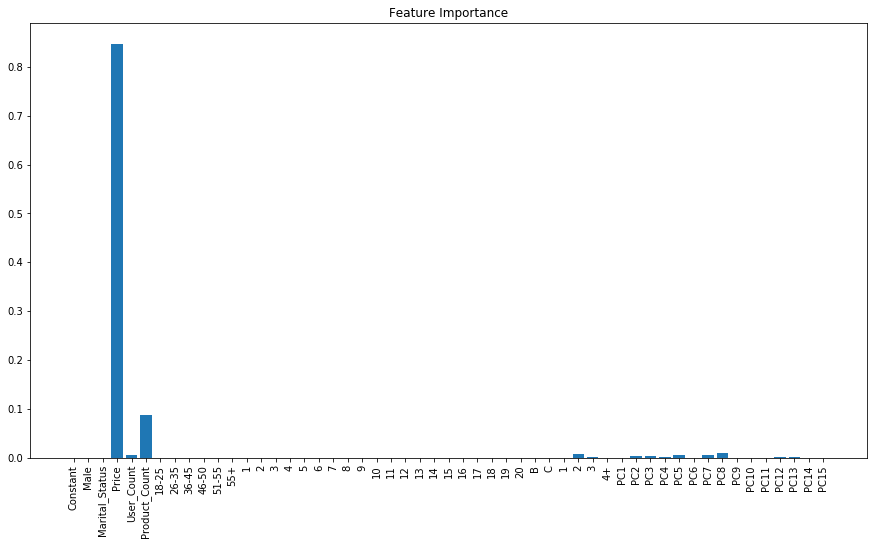

In [174]:
evaluatemodel(tree.DecisionTreeRegressor(min_impurity_decrease=0.00004,max_depth=21,min_samples_leaf=85),X,importance=True) 

This optimized model performs better than linear regression both in terms of RMSE and cross validation RMSE. This is likely because it can capture any degree of interaction between any number of features as well as nonlinear behavior.

Similar to the regression model, the price and popularity of the product is the most important, followed by product category. In the decision tree mode, the length of time in the same city has a slight effect also.

Overall the characteristics of the product has more impact on the amount a customer spends on a product than the characteristics of the customer. This indicates most purchases made on Black Friday are items that most people would want to buy. The characteristics of the customer helps refine the model, but accounts for only a small portion of the sum of squares. The rest of the variability is presumably from characteristics of the product or customers that are not extractable from the data set.